# 0. Preliminary steps

1. First we mount the Google Drive.

In [103]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. We install necessary dependencies.

In [104]:
!pip install tld

In [105]:
!pip install tqdm

3. Then we import all the necessary libraries for our project.

In [106]:
import os
import bz2
import json

import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. Data pre-processing

### **1.0** Quality of life

We maintain a data structure called `file_info` which allows us to easily reference a file with its path, and gives us the file's uncompressed size, which is useful for progress bars using `tqdm`.

In [107]:
# File info (useful for progress bars, no need to re-compute)
# File size is the size of the uncompressed file, in bytes
# n_items is the number of instances contained in the file
# In all cases, 'None' means the data hasn't been computed yet
file_info = {
    '2020': {'path':'/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2', 'size': 3850176284, 'n_items': None},
    '2019': {'path':'/content/drive/MyDrive/Quotebank/quotes-2019.json.bz2', 'size': 16354868483, 'n_items': None},
    '2018': {'path':'/content/drive/MyDrive/Quotebank/quotes-2018.json.bz2', 'size': 22665822486, 'n_items': None},
    '2017': {'path':'/content/drive/MyDrive/Quotebank/quotes-2017.json.bz2', 'size': 24502223120, 'n_items': None},
    '2016': {'path':'/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2', 'size': 10584617634, 'n_items': None},
    '2015': {'path':'/content/drive/MyDrive/Quotebank/quotes-2015.json.bz2', 'size': 14797890201, 'n_items': None},
    'test': {'path':'/content/drive/MyDrive/ADA2/quotes-test.json.bz2', 'size': 40666307, 'n_items': None},
}

In [108]:
def get_uncompressed_size(id):
  """Decompress a .bz2 file and return its size"""
  with bz2.open(file_info[id]['path'], 'rb') as f:
    f.seek(0, os.SEEK_END)
    return f.tell()

In [109]:
# Example execution (don't run, it takes ages)
# print(get_uncompressed_size('2020'))

### **1.1** Preliminary data extraction

Having computed the file sizes, we are now ready to do some preliminary data extraction and exploration. First, we check what the first line of a file looks like:

In [110]:
with(bz2.open(file_info['2020']['path'], 'rb')) as f:
  for instance in f:
    print(json.loads(instance))
    break

{'quoteID': '2020-01-28-000082', 'quotation': '[ D ] espite the efforts of the partners to create a non-political award that unites the Jewish people, some have incorrectly interpreted the participation of the Office of the Prime Minister in the Genesis Prize as bringing a political dimension to this important initiative,', 'speaker': 'None', 'qids': [], 'date': '2020-01-28 08:04:05', 'numOccurrences': 1, 'probas': [['None', '0.7272'], ['Prime Minister Netanyahu', '0.2445'], ['Natan Sharansky', '0.0283']], 'urls': ['http://israelnationalnews.com/News/News.aspx/275210'], 'phase': 'E'}


Lines are JSON strings, with many attributes, including the `quotation`. For our project, we would like to extract all quotes relating to China (and more generally Eastern Asia) from the provided datasets.<br>
We define the function `get_quotes`, which goes through a file and retrieves all elements which satisfy a predicate.

In [111]:
def get_quotes(id, predicate, out=None, out_path=None):
  """
  Get all quotes from a given file that satisfy a predicate.
  This function both writes the result to a file, if the path is specified,
  and returns a list of filtered quotes.
  """
  if ((out != None) and (out_path == None)):
    out = None
  if (out == None):
    out_path = '/content/tmp.json.bz2'
  
  # Setup progress bar
  size = file_info[id]['size']
  with tqdm(total=size) as pbar:

    with bz2.open(out_path, 'wb') as f_out:
      with bz2.open(file_info[id]['path'], 'rb') as f:
        quotes = []
        for instance in f:
          pbar.update(len(instance))
          instance = json.loads(instance)
          if (predicate(instance)):
            quotes.append(instance)
            f_out.write((json.dumps(instance)+'\n').encode('utf-8'))

      # Write information back to file_info if `out` was specified
      if (out != None):
        file_info.update({out: {
          'path':out_path, 'size': f_out.tell(), 'n_items': len(quotes)
        }})
    return quotes

We decide to focus on subtil propaganda; that means, we are not looking for quotes contening direct racial insults.

In [112]:
search_terms = [
  'China',
  'Chinese',
  'President Xi',
  'Xi Xinping',
  'Asia',
  'East Asia',
  'Xinjiang',
  'Wuhan',
  'Beijing',
  'Mandarin',
  'Chinese virus',
  'Republic of China',
]

In [113]:
# Note: all predicates should be functions with the signature:
#    (i) -> {True, False}
# where i is a parsed JSON instance from the file.

def predicate_quotation_contents(instance):
  quote = instance['quotation']
  return any(word in quote for word in search_terms)

In [114]:
# Test the code out on the 2020 dataset
test_path = '/content/drive/MyDrive/ADA2/quotes-test.json.bz2'
if (not os.path.exists(test_path)):
  print('Generating file')
  quotes = get_quotes('2020', predicate_quotation_contents, out='test', out_path=test_path)
else:
  print('File already generated, find it at {path}'.format(path=test_path))

File already generated, find it at /content/drive/MyDrive/ADA2/quotes-test.json.bz2


In [115]:
# Get an idea of the retrieved data
with(bz2.open(file_info['test']['path'], 'rb')) as f:
  for instance in f:
    print(json.loads(instance))
    break

print(file_info['test'])

{'quoteID': '2020-02-07-008586', 'quotation': "Asian inclusion and celebrating diversity more widely are a key focus for us and, having recently met with the president and senior officials of the All Nepal Football Association (ANFA), and the Nepali minister for youth and sport, we share their excitement for this event. We're looking forward to sharing this experience with the local community in Aldershot.", 'speaker': 'Laurence Jones', 'qids': ['Q26884000', 'Q27430504'], 'date': '2020-02-07 10:43:24', 'numOccurrences': 1, 'probas': [['Laurence Jones', '0.7837'], ['None', '0.2055'], ['Paul Fairclough', '0.0108']], 'urls': ['http://www.thefa.com/news/2020/feb/07/england-c-to-play-nepal-in-aldershot-070220'], 'phase': 'E'}
{'path': '/content/drive/MyDrive/ADA2/quotes-test.json.bz2', 'size': 40666307, 'n_items': None}


/!\ Some quotes have multiple QID in the column "qids" referencing the same name, we will see later how to resolve this problem.

We create `file_to_dataframe`which will able us to load our retrieved quotes into a pandas Dataframe (easier to analyse).

In [116]:
def file_to_dataframe(id):
  """Read a .bz2 file of JSON instances and load the data in a Pandas DataFrame"""
  instances = []
  with tqdm(total=file_info[id]['size']) as pbar:
    with bz2.open(file_info[id]['path'], 'rb') as f:
      for instance in f:
        pbar.update(len(instance))
        instances.append(json.loads(instance))

  quotes_df = pd.DataFrame(instances)
  return quotes_df

We test `file_to_dataframe`on the 2020 data to observe more the information that we can get about a quotation.

In [117]:
# Load the quotes retrieved in part 1 (still only test 2020 data)
quotes_df = file_to_dataframe('test')
quotes_df

100%|██████████| 40666307/40666307 [00:08<00:00, 4571769.74it/s]


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-02-07-008586,Asian inclusion and celebrating diversity more...,Laurence Jones,"[Q26884000, Q27430504]",2020-02-07 10:43:24,1,"[[Laurence Jones, 0.7837], [None, 0.2055], [Pa...",[http://www.thefa.com/news/2020/feb/07/england...,E
1,2020-03-03-009635,Concerns about current and ongoing reliable As...,None,[],2020-03-03 02:32:50,2,"[[None, 0.904], [Jim Bianco, 0.096]]",[http://www.arkansasonline.com/news/2020/mar/0...,E
2,2020-04-09-018179,I can't believe he's talking about politics wh...,President Trump,[Q22686],2020-04-09 08:45:13,1,"[[President Trump, 0.7307], [None, 0.2433], [T...",[https://www.prisonplanet.com/disgusting-who-c...,E
3,2020-01-24-035543,I think there should be an arm's length relati...,None,[],2020-01-24 01:51:00,4,"[[None, 0.9213], [David Perry, 0.0641], [Meng ...",[http://bc.ctvnews.ca/security-guard-enforcing...,E
4,2020-04-09-028183,in the pocket of China,Tom Cotton,[Q3090307],2020-04-09 00:00:00,2,"[[Tom Cotton, 0.7595], [None, 0.2075], [Tedros...",[http://www.foxnews.com/media/sen-tom-cotton-w...,E
...,...,...,...,...,...,...,...,...,...
46259,2020-03-02-055278,The game in China will be officially cancelled...,Theo Doropoulos,[Q7781445],2020-03-02 21:47:23,1,"[[Theo Doropoulos, 0.9072], [None, 0.0654], [S...",[http://fiveaa.com.au/sport/reports-port-adela...,E
46260,2020-02-27-070818,The sudden outbreak of a new coronavirus is ve...,Chandra Wickramasinghe,[Q765741],2020-02-27 15:05:40,1,"[[Chandra Wickramasinghe, 0.6195], [None, 0.38...",[https://wegotthiscovered.com/movies/british-s...,E
46261,2020-01-28-085486,There are indications that the US is inclined ...,Salman Bashir,[Q7405401],2020-01-28 09:24:00,3,"[[Salman Bashir, 0.8075], [None, 0.1925]]",[http://articles.economictimes.indiatimes.com/...,E
46262,2020-04-06-053986,Videos and stories from #Guangzhou are appalli...,Tibor Nagy,"[Q1214529, Q1214530, Q56065706, Q7800491, Q780...",2020-04-06 08:17:33,1,"[[Tibor Nagy, 0.8909], [None, 0.1091]]",[http://www.africanews.com/2020/04/15/coronavi...,E


# 2. Speakers analysis

## 2.1 Relevant speaker attributes

First we do not keep all information about each speaker but only the name(`label`),the nationality (`nationality`), the ethnic group (`ethnic_group`), the political party they are associated with (`party`), the occupation (`occupation`) and the main QID using to label them (`id`).

In [118]:
#attributes of the speaker, relative to his id
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/Project datasets/speaker_attributes.parquet', engine='pyarrow', columns= ['label','nationality', 'ethnic_group', 'party','id', 'occupation'] )
speaker_attributes.head()

,label,nationality,ethnic_group,party,id,occupation
0,George Washington,"[Q161885, Q30]",None,[Q327591],Q23,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ..."
1,Douglas Adams,[Q145],[Q7994501],None,Q42,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422..."
2,Paul Otlet,[Q31],None,None,Q1868,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q..."
3,George W. Bush,[Q30],None,[Q29468],Q207,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408..."
4,Diego Velázquez,[Q29],None,None,Q297,[Q1028181]


Then we take only the speakers that appear in our filtered dataset **quotes_df**.

In [119]:
#create table of all qids of people that are in quotes_df
qids_quotes = []
for qids in quotes_df["qids"]:
  for qid in qids:
    qids_quotes.append(qid)
qids_quotes = pd.DataFrame(qids_quotes, columns=['id'])

In [120]:
#We do the intersection to retrieve only the speakers of our quotes_df
speakers = pd.merge(speaker_attributes, qids_quotes, how='inner', on=['id']).drop_duplicates(subset=['id'])
speakers.head()

,label,nationality,ethnic_group,party,id,occupation
0,George W. Bush,[Q30],None,[Q29468],Q207,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408..."
3,Narendra Modi,[Q668],"[Q1282294, Q6889284]",[Q10230],Q1058,"[Q82955, Q36180, Q7019111, Q10429346]"
76,Ban Ki-moon,[Q884],[Q484464],[Q327591],Q1253,"[Q82955, Q193391]"
80,Justin Chadwick,[Q145],None,None,Q3671,"[Q33999, Q10800557, Q2526255, Q2059704, Q10798..."
81,Mitt Romney,[Q30],None,[Q29468],Q4496,"[Q82955, Q15978655, Q43845, Q15980158, Q219477]"


We found out that the QID *Q30* represents the american nationality. So we are looking to know how many americans we have in our retrieved quotes.
We do the same analysis with white peaple (*Q235155*) and people whith asian background (*Q4058325*).

In [121]:
#return max of element in a column a row can have
def max_element(column):
  max = 0;
  for e in column:
    if e is not None:
      if(len(e) > max):
        max = len(e)
        qids = e
  return [max, qids]

In [122]:
#test how many nationalities someone can have at most
max_nat = max_element(speakers.nationality)
print("The maximum number of nationalities of a speaker in our quotes is ", max_nat[0]," nationalities. Their QID are:", max_nat[1])

The maximum number of nationalities of a speaker in our quotes is  5  nationalities. Their QID are: ['Q654342' 'Q750583' 'Q217169' 'Q890120' 'Q954']


In [123]:
#test how many ethnies someone can have at most
max_ethn = max_element(speakers.ethnic_group)
print("The maximum number of ethnies of a speaker in our quotes is ",max_ethn[0], "ethnies. Their qids are ", max_ethn[1])

The maximum number of ethnies of a speaker in our quotes is  6 ethnies. Their qids are  ['Q39086965' 'Q49085' 'Q6127409' 'Q7681242' 'Q2643509' 'Q6935055']


In [124]:
#take only rows than contain a specific qid in a specific column
def get_rows_by_qids(column, qid, max_element_in_cell):
  result = speakers.loc[speakers[column].str[0] == qid]
  for i in range(1, max_element_in_cell):
    result = pd.concat([result, speakers.loc[speakers[column].str[i] == qid]], 
                                ignore_index=True)
  return result

In [125]:
#Q30 = Americans
american_speakers = get_rows_by_qids("nationality", "Q30", max_nat[0])
american_speakers.head()

,label,nationality,ethnic_group,party,id,occupation
0,George W. Bush,[Q30],None,[Q29468],Q207,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408..."
1,Mitt Romney,[Q30],None,[Q29468],Q4496,"[Q82955, Q15978655, Q43845, Q15980158, Q219477]"
2,David Paterson,[Q30],[Q49085],[Q29552],Q11674,[Q82955]
3,Jimmy Carter,[Q30],None,[Q29552],Q23685,"[Q10669499, Q193391, Q6625963, Q82955, Q131512..."
4,Todd Young,[Q30],None,[Q29468],Q25483,"[Q82955, Q40348, Q47064, Q15978655]"


In [126]:
#Q235155 = white people
american_white_speakers = get_rows_by_qids("ethnic_group", "Q235155", max_ethn[0])
american_white_speakers.head()

,label,nationality,ethnic_group,party,id,occupation
0,Bill Clinton,[Q30],[Q235155],[Q29552],Q1124,"[Q82955, Q40348, Q193391, Q18814623, Q36180, Q..."


In [127]:
#Q4058325 = asian people
asian_american_speakers = get_rows_by_qids("ethnic_group", "#Q4058325", max_ethn[0])
asian_american_speakers.head()

,label,nationality,ethnic_group,party,id,occupation


In [128]:
print("We have", american_speakers.shape[0], "american native speakers in our retrieved quotes.")
print("We have", american_white_speakers.shape[0], "white american speakers in our retrieved quotes.")
print("We have", asian_american_speakers.shape[0], "asian american speakers in our retrieved quotes.")

We have 4970 american native speakers in our retrieved quotes.
We have 1 white american speakers in our retrieved quotes.
We have 0 asian american speakers in our retrieved quotes.


What we can conclude:    
*   We have a lot of american speakers in our retrieved quotes.
*   We have only one white american speaker and no asian american in our retrieved quotes. It seems that not all of the speakers have an ethnie specified.

We will analyse quotations of american speakers and we will not focus on the ethnic groups.


We decided to keep only quotes from american speakers.

In [129]:
#test how many qids can a quote have at most
max_element(quotes_df.qids)
print(max, qids)

451 ['Q7000915', 'Q7331387', 'Q7331389']


In [130]:
#dataframe with all quotes that involve americans
americans_speakers_quotes = quotes_df.loc[quotes_df['qids'].str[0].isin(american_speakers["id"])]
for i in range(1, 451):
  americans_speakers_quotes = pd.concat([americans_speakers_quotes, 
                                 quotes_df.loc[quotes_df['qids'].str[i].isin(american_speakers["id"])]], 
                                ignore_index=True)
americans_speakers_quotes.shape

(19113, 9)

In [131]:
americans_speaker_quotes = americans_speakers_quotes.drop_duplicates(subset=["quotation"])
print(americans_speaker_quotes.shape)

(13216, 9)


We have a dataset of 13216 quotes attributed to Americans that is related to China.

## 2.2 organization of attributes

Then we will need the wikidata information about what each identifier QID correspond to.

In [132]:
#what does QID correspond to
wikidata_labels = pd.read_csv('/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2')
wikidata_labels.head()

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe
2,Q75,Internet,global system of connected computer networks
3,Q148,People's Republic of China,sovereign state in East Asia
4,Q155,Brazil,country in South America


In [133]:
#Find the label corresponding to a QID
#return -1 if the QID is not available in 'wikidata_labels'
def QID_to_attribute(QID):
  if((wikidata_labels[wikidata_labels.QID == QID]).empty):
    return -1
  return (wikidata_labels[wikidata_labels.QID == QID])["Label"].iat[0]

##2.3 Multiple qids for one speaker

As said, some quotes have multiple qids to reference only one speaker. We found out that one of this qids is correct and the other ones are either not available in wikidata_labels (and wikidata online) or referencing someone with the exact same name. Let's see how many quotes have this problem => if not too many, we can fix this manually.

In [134]:
#how many quotes have multiple qids for the same author
count = 0
for q in quotes_df.qids:
  if len(q) >= 2:
    count+=1
print(count)

8639


There is 8639 quotes with the problem stated above => too much to fix it manually. For now we will only consider the first one. If the first one is not available in the dataset, we take the next one and so on.

In [135]:
#get the speaker of a specific quote
def qid_speaker(quoteID):
  quote = quotes_df[quotes_df.quoteID == quoteID]
  qids = quote.qids[0]
  qid = ""
  for q in qids:
    if(QID_to_attribute(q) != -1):
      qid = q
  if qid == "":
    return "Qid of speaker not available in the dataset"
  return qid


# 3. Additional dataset: Empath

We want know to analyse the sentiment of quotes related to China thanks to an appropriate pre-trained model, **Empath**.

In [136]:
!pip install empath

     |████████████████████████████████| 57 kB 2.5 MB/s 
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57821 sha256=1c736b0e61904b47e493fe28888b1dd5d641acf33d41de02ee5fffefbf5ec9a7
  Stored in directory: /root/.cache/pip/wheels/2b/78/a8/37d4505eeae79807f4b5565a193f7cfcee892137ad37591029
Successfully built empath


In [137]:
import matplotlib.pyplot as plt

%matplotlib inline

from empath import Empath

In [138]:
lexicon = Empath()

In [139]:
# Get list of all current categories
print(list(lexicon.analyze(americans_speaker_quotes['quotation'][0], normalize=True).keys()))

['help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine', 'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking', 'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule', 'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving', 'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet', 'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body', 'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death', 'healing', 'legend', 'heroic', 'celebr

In [140]:
all_categories = ['help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine', 'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking', 'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule', 'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving', 'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet', 'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body', 'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death', 'healing', 'legend', 'heroic', 'celebration', 'restaurant', 'violence', 'programming', 'dominant_heirarchical', 'military', 'neglect', 'swimming', 'exotic', 'love', 'hiking', 'communication', 'hearing', 'order', 'sympathy', 'hygiene', 'weather', 'anonymity', 'trust', 'ancient', 'deception', 'fabric', 'air_travel', 'fight', 'dominant_personality', 'music', 'vehicle', 'politeness', 'toy', 'farming', 'meeting', 'war', 'speaking', 'listen', 'urban', 'shopping', 'disgust', 'fire', 'tool', 'phone', 'gain', 'sound', 'injury', 'sailing', 'rage', 'science', 'work', 'appearance', 'valuable', 'warmth', 'youth', 'sadness', 'fun', 'emotional', 'joy', 'affection', 'traveling', 'fashion', 'ugliness', 'lust', 'shame', 'torment', 'economics', 'anger', 'politics', 'ship', 'clothing', 'car', 'strength', 'technology', 'breaking', 'shape_and_size', 'power', 'white_collar_job', 'animal', 'party', 'terrorism', 'smell', 'disappointment', 'poor', 'plant', 'pain', 'beauty', 'timidity', 'philosophy', 'negotiate', 'negative_emotion', 'cleaning', 'messaging', 'competing', 'law', 'friends', 'payment', 'achievement', 'alcohol', 'liquid', 'feminine', 'weapon', 'children', 'monster', 'ocean', 'giving', 'contentment', 'writing', 'rural', 'positive_emotion', 'musical']

The output produced by running Empath on a quote is a dictionary associating a float value to each of the above categories. Looking at these categories, we can define some as being "positive" or "negative" in the context of media coverage. We split these categories manually below. 

Furthermore, we associate each of these categories with a weight, which prevent situations where equal mentions of `war` (classified as negative) and `wedding` (classified as positive) "cancel" each other out and are considered to be of equal emotional strength. To determine these weights, we sort the categories by order of magnitude (i.e. `war` is worse than `dispute`, which is worse than `confusion`). We then create a matrix where each element compares the line (the positive element) to the column (the negative element); if the positive emotion outweighs the negative emotion, the element is set to 1, and 0 otherwise. Then, the weights of the positive emotions are equal to the number of negative emotions they outweigh, and the weights of the negative emotions are set to `w-1` where `w` is the weight of the positive category that outweighs them.

In [141]:
negative_categories = {
    'death': 29,
    'war': 29,
    'kill': 29,
    'suffering': 29,
    'aggression': 29,
    'terrorism': 29,
    'crime': 28,
    'rage': 25,
    'hate': 25,
    'pain': 24,
    'monster': 24,
    'weapon': 24,
    'military': 24,
    'violence': 24,
    'anger': 24,
    'horror': 22,
    'dispute': 22,
    'fight': 22,
    'disgust': 22,
    'fear': 21,
    'ridicule': 21,
    'stealing': 21,
    'prison': 21,
    'neglect': 21,
    'injury': 20,
    'dominant_heirarchical': 20,
    'torment': 20,
    'deception': 19,
    'shame': 19,
    'irritability': 19,
    'sadness': 18,
    'weakness': 13,
    'envy': 13,
    'poor': 12,
    'breaking': 12,
    'negative_emotion': 10,
    'ugliness': 8,
    'fire': 8,
    'confusion': 7,
    'swearing_terms': 7,
    'competing': 7,
    'disappointment': 7,
    'medieval': 7,
    'nervousness': 4,
    'exasperation': 4,
    'worship': 3,
    'childish': 3,
    'wealthy': 3,
    'pride': 2,
    'cold': 2,
}

In [142]:
positive_categories = {
    'divine': 30,
    'heroic': 30,
    'leader': 29,
    'independence': 26,
    'strength': 25,
    'trust': 25,
    'achievement': 25,
    'valuable': 25,
    'love': 23,
    'celebration': 22,
    'joy': 21,
    'beauty': 20,
    'leisure': 19,
    'family': 14,
    'affection': 14,
    'attractive': 14,
    'optimism': 14,
    'friends': 14,
    'cheerfulness': 13,
    'positive_emotion': 11,
    'sympathy': 11,
    'politeness': 9,
    'contentment': 9,
    'communication': 8,
    'magic': 5,
    'gain': 5,
    'giving': 5,
    'zest': 4,
    'wedding': 3,
    'play': 0,
    'toy': 0,
}

In [143]:
neutral_categories = set(all_categories) - (set(negative_categories.keys()).union(set(positive_categories.keys())))

# Make sure there is no overlap between negative and positive categories:
assert(not set(negative_categories.keys()).intersection(set(positive_categories.keys())))

In [144]:
def remove_categories(result_in, predicate):
  """Remove all categories from a result that satisfy a given predicate.<br>
     ex: `remove_categories(result, lambda k, v: v < 0.5)` removes all categories
     where the value is less than 0.5"""
  result = result_in.copy()
  for k, v in list(result.items()):
    if (predicate(k, v)):
      del result[k]
  return result

In [145]:
def weigh_result(categories, result):
  """Multiply the results of an Empath analysis by the weight of their categories"""
  res = result.copy()
  for k, v in res.items():
    res[k] = v * categories[k]

  return res

In [146]:
res = []
analysis_categories = negative_categories.copy()
analysis_categories.update(positive_categories)

category_is_null = lambda k, v: v == 0

# Analyze quotes using both negative and positive categories
with tqdm(total=len(americans_speaker_quotes['quotation'])) as pbar:
  for ind, quote in enumerate(americans_speaker_quotes['quotation']):
    # We purposefully do not normalize the results as we want them to reflect
    # how influential the model considers the category to be, generally speaking,
    # not how influential the category is within the quote.
    res.append(lexicon.analyze(quote, categories=analysis_categories, normalize=False))

    # Removal of all categories where the value is 0 (is this necessary ?)
    res[ind] = remove_categories(res[ind], category_is_null)

    # Apply the weights to all the results
    res[ind] = weigh_result(analysis_categories, res[ind])
    
    pbar.update(1)

100%|██████████| 13216/13216 [00:46<00:00, 287.30it/s]


Now that we have the results of the Empath analysis on all considered quotes, we can proceed to some visualizations. We start by computing the mean of each category across all quotes:

In [147]:
# Get the average of every category for every quote
category_entries = {}
category_sum = {}

for cat in all_categories:
  category_entries.update({cat: 0})
  category_sum.update({cat: 0})

for result in res:
  for key, value in result.items():
    category_entries.update({key: category_entries[key] + 1})
    category_sum.update({key: category_sum[key] + value})

category_averages = {}
n = len(res)
for key, value in category_sum.items():
  category_averages.update({key: value / n})

category_averages

{'achievement': 2.426982445520581,
 'affection': 0.3802966101694915,
 'aggression': 2.4444612590799033,
 'air_travel': 0.0,
 'alcohol': 0.0,
 'ancient': 0.0,
 'anger': 0.48849878934624696,
 'animal': 0.0,
 'anonymity': 0.0,
 'anticipation': 0.0,
 'appearance': 0.0,
 'art': 0.0,
 'attractive': 0.4491525423728814,
 'banking': 0.0,
 'beach': 0.0,
 'beauty': 0.32990314769975787,
 'blue_collar_job': 0.0,
 'body': 0.0,
 'breaking': 0.4957627118644068,
 'business': 0.0,
 'car': 0.0,
 'celebration': 1.2901029055690072,
 'cheerfulness': 0.1603359564164649,
 'childish': 0.08784806295399515,
 'children': 0.0,
 'cleaning': 0.0,
 'clothing': 0.0,
 'cold': 0.07808716707021791,
 'college': 0.0,
 'communication': 1.2330508474576272,
 'competing': 0.4290254237288136,
 'computer': 0.0,
 'confusion': 0.3119703389830508,
 'contentment': 0.16343825665859565,
 'cooking': 0.0,
 'crime': 1.5423728813559323,
 'dance': 0.0,
 'death': 1.18931598062954,
 'deception': 0.8482142857142857,
 'disappointment': 0.15677

In [148]:
final_cat_averages = remove_categories(category_averages, category_is_null)
pos_cat_averages = dict(sorted(remove_categories(final_cat_averages, lambda key, value: key in negative_categories).items(), key=lambda x: x[1]))
neg_cat_averages = dict(sorted(remove_categories(final_cat_averages, lambda key, value: key in positive_categories).items(), key=lambda x: x[1]))

In [149]:
def plot_analysis_histogram(quote, analysis):
  colors = ['b' if (cat in positive_categories) else 'r' for cat in list(analysis.keys())]
  plt.bar(*zip(*analysis.items()), color=colors)
  plt.xlabel('Category')
  plt.ylabel('Connotation value (measured by Empath)')
  plt.xticks(list(analysis.keys()), rotation='vertical')
  plt.suptitle(quote)
  
  plt.show()

We use the following cell to check that the analyses provided by the model and our weighing scheme are consistent with our expectations and observations.

I would like to go down to a lower number because I want to either bring those
troops home so they can refit and retrain for other missions, or be redeployed
to the Indo-Pacific to face off our greatest challenge in terms of the great
power competition -- that's vis-a-vis China,


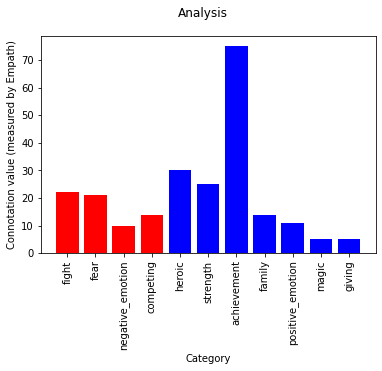

In [150]:
from random import randint
import textwrap

i = randint(0, len(americans_speaker_quotes['quotation']))
print(textwrap.fill(americans_speaker_quotes['quotation'][i], width=80))
if (not res[i]):
  print('\nEmpath did not attribute any of the considered categories to this quote.')
else:
  plot_analysis_histogram("Analysis", res[i])

Finally, we plot the weighted results obtained through Empath:

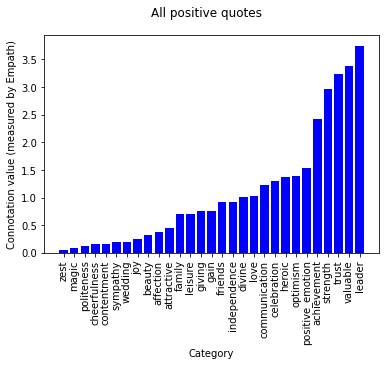

In [151]:
plot_analysis_histogram("All positive quotes", pos_cat_averages)

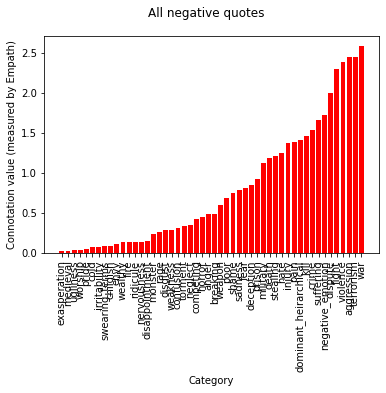

In [152]:
plot_analysis_histogram("All negative quotes", neg_cat_averages)

The following cell gives us a better idea of the prevalence of positive or negative ideas across the quotes we have filtered:


In [153]:
pos_sum = 0
neg_sum = 0

for key, value in neg_cat_averages.items():
  neg_sum += value

for key, value in pos_cat_averages.items():
  pos_sum += value

print('Sum of positive categories: {pos:.4f}\nSum of negative categories: {neg:.4f}'.format(pos=pos_sum, neg=neg_sum))

Sum of positive categories: 31.7076
Sum of negative categories: 40.2304
